In [1]:
# Change here using YOUR own first and last names
fn1 = "samy"
ln1 = "aimeur"
filename = "_".join(map(lambda s: s.strip().lower(),
["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"
filename

'sd-tsia204_lab2_aimeur_samy.ipynb'

# TP 2 Linear regression

    Question 1.a)

In [2]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as skd
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import random 
from scipy.stats import t
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.decomposition import PCA

In [3]:
ca_data=skd.fetch_california_housing()
X = ca_data.data ; Y = ca_data.target
X = np.hstack((np.ones((X.shape[0], 1)), X))

teta = np.linalg.inv(X.T @ X) @ (X.T).dot(Y)

# table to resume the results
print('Results :')
results = pd.DataFrame({"teta0" : [teta[0]], "teta1" : [teta[1]], "teta2" : [teta[2]], "teta3" : [teta[3]], "teta4" : [teta[4]], "teta5" : [teta[5]], "teta6" : [teta[6]], "teta7" : [teta[7]], "teta8" : [teta[8]]})
results = pd.DataFrame(teta.reshape((1,9)), columns =["intercept"]+ca_data.feature_names)
print(results)

Results :
   intercept    MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
0  -36.94192  0.436693  0.009436 -0.107322   0.645066   -0.000004 -0.003787   

   Latitude  Longitude  
0 -0.421314  -0.434514  


In [4]:
def mse(Y2, Y):
    return np.sum((Y2 - Y)**2)/Y.shape[0]

def R2(Y2, Y):
    return 1 - np.sum((Y2- Y)**2)/np.sum((Y - np.mean(Y))**2)

#table to resume the results
print('Results :')
results = pd.DataFrame({"R2" : [r2_score(Y, X @ teta), R2(X @ teta, Y) ], "MSE" : [mean_squared_error(Y, X @ teta), mse(X @ teta, Y)]}, index=["sklearn", "manual"])
print(results)

Results :
               R2       MSE
sklearn  0.606233  0.524321
manual   0.606233  0.524321


    Question 1.b

In [5]:
n= X.shape[0] ; p = X.shape[1]-1

CI = [0 for i in range(9)]
alpha = 0.01
quantil = t.ppf(1-alpha/2, n-p-1)

sigma2 = np.sum((Y - X @ teta)**2)/(n-p-1)
sigma = np.sqrt(sigma2)

inv_XtX = np.linalg.inv(X.T @ X)

for i in range(p+1):
    CI[i] = [teta[i] - quantil*sigma*np.sqrt(inv_XtX[i,i]), teta[i] + quantil*sigma*np.sqrt(inv_XtX[i,i])]

dic = {"teta" : teta, "CI" : CI}
print(pd.DataFrame(dic, index=["intercept"]+ca_data.feature_names))

                 teta                                              CI
intercept  -36.941920         [-38.6392765560449, -35.24456385978912]
MedInc       0.436693       [0.42588204512769606, 0.4475045411374747]
HouseAge     0.009436    [0.008286131981757795, 0.010585424084470666]
AveRooms    -0.107322    [-0.12248317646178496, -0.09216090631672623]
AveBedrms    0.645066        [0.5725881772785845, 0.7175432097522406]
Population  -0.000004  [-1.621064574367914e-05, 8.25786690048907e-06]
AveOccup    -0.003787  [-0.00504215628365078, -0.0025309290262501873]
Latitude    -0.421314    [-0.43985399169032136, -0.40277476337980567]
Longitude   -0.434514    [-0.45391898908557515, -0.41510852028078127]


    Question 2.a

In [6]:
random.seed(0)

In [7]:
# Load the dataset
data = pd.read_csv("data.csv", header=None)

# Separate features and target variable
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Standardize target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    Question 2.b

In [8]:
# Fit a regular OLS
ols_model = LinearRegression(fit_intercept=False) # We already standardized the features
ols_model.fit(X_train_scaled, y_train_scaled)

print('Results :')
results = pd.DataFrame({"R2" : [R2(ols_model.predict(X_train_scaled), y_train_scaled) ], "MSE" : [mse(ols_model.predict(X_train_scaled), y_train_scaled)]})
print(results)

Results :
        R2      MSE
0  0.55914  0.44086


    Question 3.a

In [24]:
def variable_selection(X, Y, S = []):
    n = X.shape[0]
    p = X.shape[1]
    p_values = [1 for i in range(p)] #initialisation
    Yhat_list = [0 for i in range(p)]
    for i in range(p):
        if i in S:
            p_values[i]=1
        else:
            Xi = X[:,i].reshape(-1,1)
            model = LinearRegression(fit_intercept=False).fit(Xi , Y)
            teta = model.coef_[0] 
            Y_hat = model.predict(Xi)
            sigma2 = np.sum((Y - Y_hat)**2)/(n-2)
            sigma = np.sqrt(sigma2)
            s2 = 1/(Xi.T @ Xi)[0,0]
            s = np.sqrt(s2)
            T = teta/(sigma*s)
            p_values[i] = 2*(1-t.cdf(abs(T), n-2))
            Yhat_list[i] = Y_hat
    i_min = np.argmin(p_values)
    return i_min, p_values[i_min],p_values, teta, Yhat_list[i_min]

In this question, we proceed with variable selection. We test the null hypothesis $H_0$ : {$ \theta_i^*  = 0 $} . 

If the p-value $< \alpha $ we reject $H_0$. 

If the p-value $> \alpha $ we do not have enough evidence to reject $H_0$. 

In conslusion, the closer the p-value is to 0, the farther $\theta_i^*$ is from 0.

    Question 3.b/3.c

In [25]:
def forward_variable_selection(X,Y,k = X.shape[1]):
    np.set_printoptions(precision=1)
    S = []
    p_values = []
    pp_values = []
    for i in range(k):
        ind, p, pp, teta, Y_hat = variable_selection(X,Y,S)
        if p>0.05:
            break
        S.append(ind)
        pp_values.append(pp)
        p_values.append(p)
        Y = Y - Y_hat #We put the residual in Y to delete the effect of the variable we just added
    return S, p_values, np.array(pp_values)

S, p_values, pp_values =forward_variable_selection(X_train_scaled,y_train_scaled)

print('The selected variables are :' , S)
print('The p-values are :' , p_values)
print('The algorithm stopped at step :' , len(S))

The selected variables are : [34, 58, 79, 123, 135, 167, 30, 77, 168, 174, 129, 183, 13]
The p-values are : [0.0, 0.0, 6.863533075218697e-09, 2.2129867796039093e-06, 0.0026114638172500815, 0.0004382713118362691, 0.004190059476497421, 0.011912586328872043, 0.006972420788749156, 0.013941830023431079, 0.02749699916204862, 0.04437968054935837, 0.045207980771313494]
The algorithm stopped at step : 13


    Question 3.c

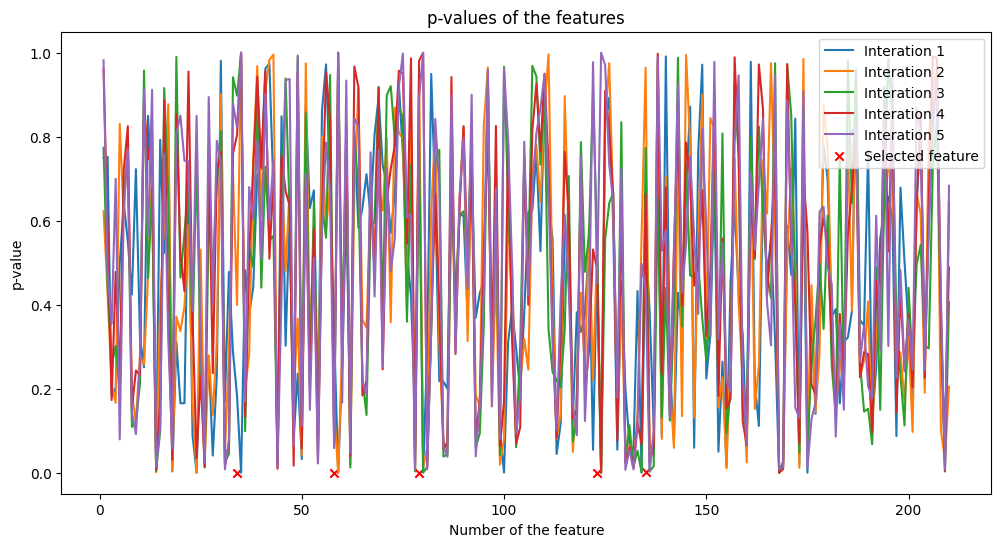

In [26]:
plt.figure(figsize=(12, 6))
for i in range(5):
    abscise = np.linspace(1,pp_values.shape[1],pp_values.shape[1])
    plt.plot(abscise, pp_values[i], label="Interation "+str(i+1))
    plt.legend()
    plt.xlabel("Number of the feature")
    plt.ylabel("p-value")
    plt.title("p-values of the features")
plt.scatter(S[:5], p_values[:5], marker = 'x', color = 'red', label = "Selected feature")
plt.legend( loc ='upper right')
plt.show()

    Question 4.a

In [27]:
def test(X,Y, model, alpha_list):
    teta_list = []
    R2_list = []
    for alpha1 in alpha_list:
        model.set_params(alpha=alpha1, max_iter=10000)
        model.fit(X,Y)
        teta_list.append(model.coef_)
        R2_list.append(model.score(X, Y))
    teta_list = np.array(teta_list)
    R2_list = np.array(R2_list)

    # Plot the evolution of coefficients
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(alpha_list, teta_list)
    plt.xscale('log')
    plt.xlabel('Alpha (Penalty Parameter)')
    plt.ylabel('Coefficient Value')
    plt.title('Evolution of Coefficients')

    # Plot the evolution of R-squared values
    plt.subplot(1, 2, 2)
    plt.plot(alpha_list, R2_list, marker='o')
    plt.xscale('log')
    plt.xlabel('Alpha (Penalty Parameter)')
    plt.ylabel('R-squared Value')
    plt.title('Evolution of R-squared Values')

    plt.tight_layout()
    plt.show()

    Question 4.b

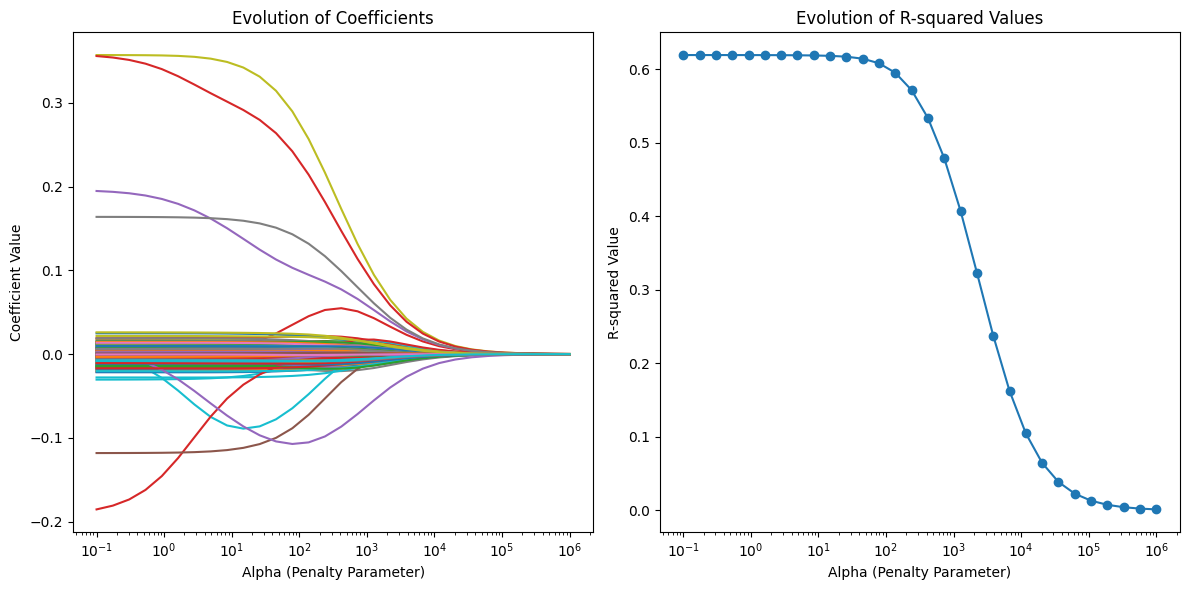

In [28]:
alpha_list = np.logspace(-1, 6, 30)
test(X_train_scaled,y_train_scaled, Ridge(), alpha_list)

    Question 5

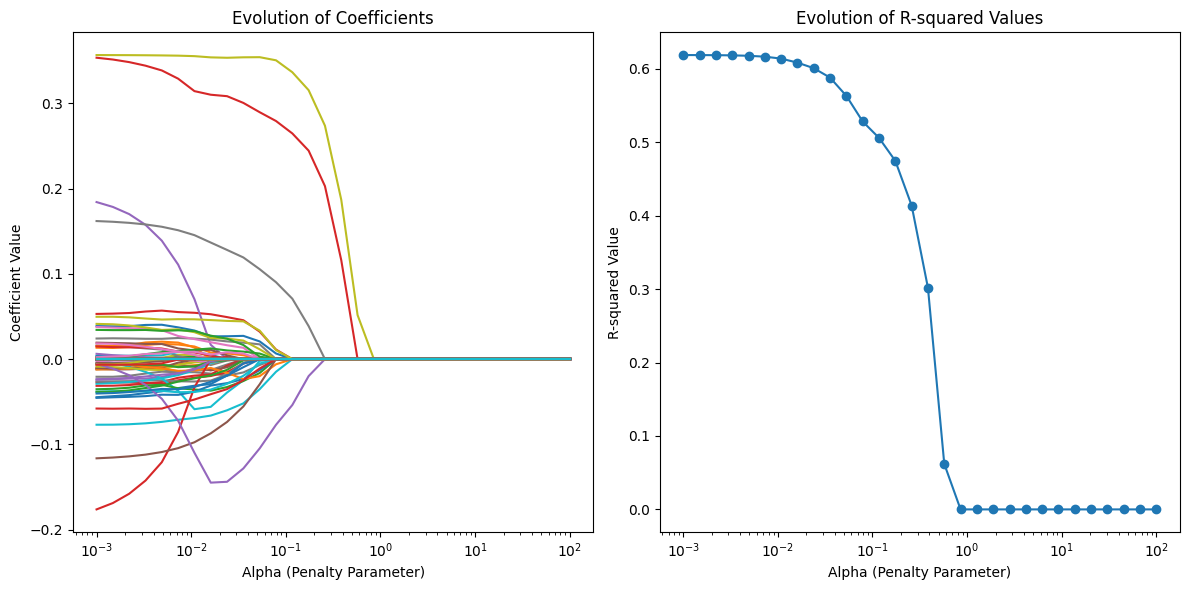

In [29]:
alpha_list = np.logspace(-3, 2, 30)
test(X_train_scaled,y_train_scaled, Lasso(), alpha_list)

    Question 6

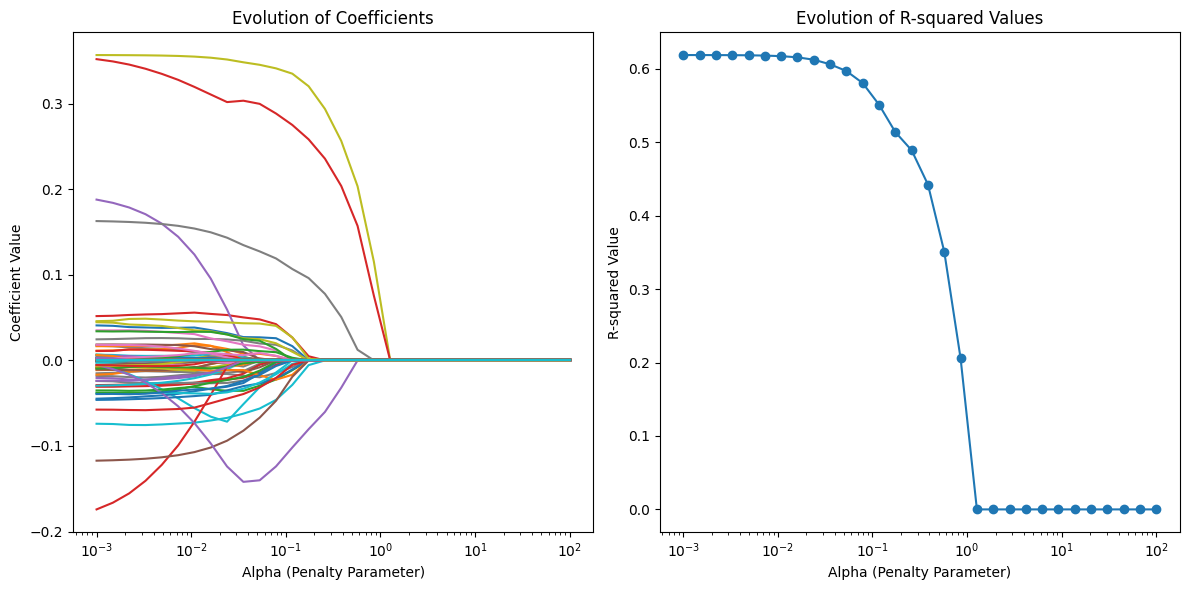

In [30]:
alpha_list = np.logspace(-3, 2, 30)
test(X_train_scaled,y_train_scaled, ElasticNet(), alpha_list) #l1_ratio=0.5

    Question 7.a

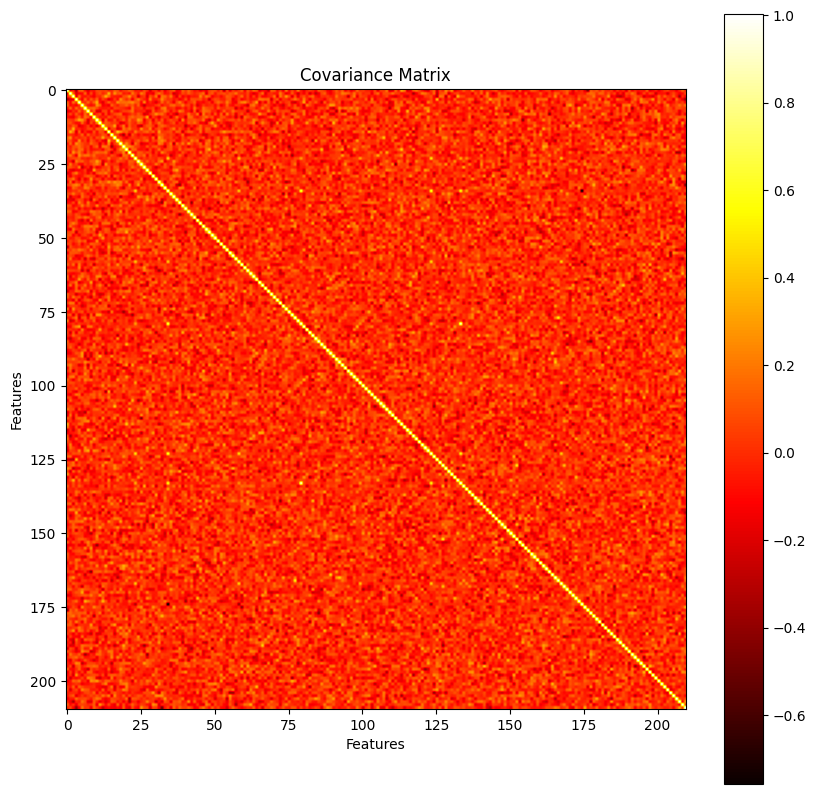

In [31]:
cov_matrix = np.cov(X_train_scaled, rowvar=False)
plt.figure(figsize = (10, 10))
plt.imshow(cov_matrix, cmap='hot')
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Covariance Matrix')
plt.colorbar()
plt.show()

    Question 7.b

I'm doing the SVD of $X$ such that $X= USV^T$

The principales $v_1, ...,v_m$ axes are the column of $V$ and they are also the eigen vector of the matrix $XX^T$ which represents the unormalised covariance matrix

In [32]:
#Compute PCA using SVD
U, s, Vt = np.linalg.svd(X_train_scaled)
pca = PCA(svd_solver = 'full').fit(X_train_scaled)

    Question 7.c

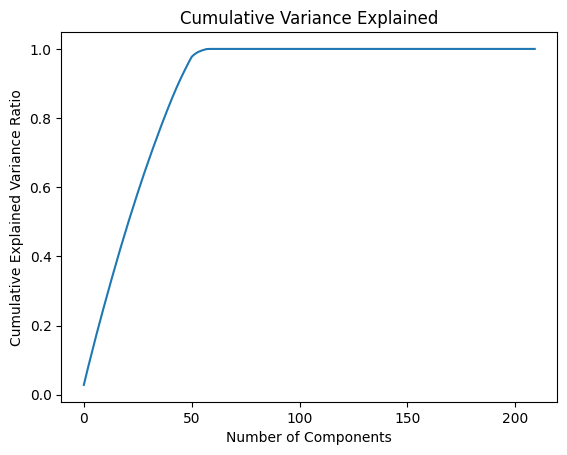

In [33]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance_ratio)
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

In [34]:
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.9) + 1
print("Number of components to explain more than 90% variance:", n_components_90)

Number of components to explain more than 90% variance: 45


    Question 7.d

$X * (v_1, v_2)$ is the new projected data set 

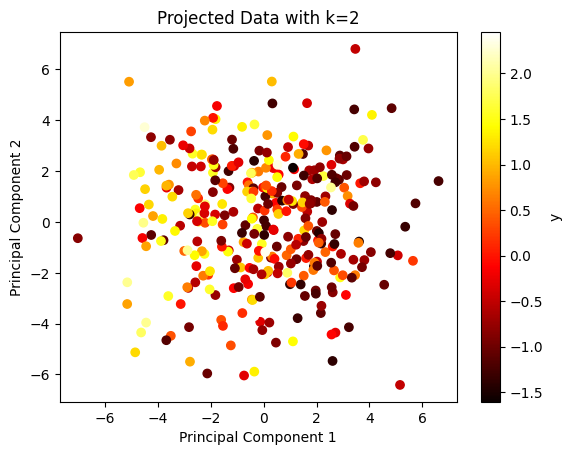

In [35]:
# Plot projected data with color as y
projected_data=X_train_scaled.dot(Vt[:2].T)
plt.scatter(projected_data[:, 0], projected_data[:, 1], c=y_train_scaled, cmap='hot')
plt.colorbar(label='y')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Projected Data with k=2')
plt.show()

    Question 7.e

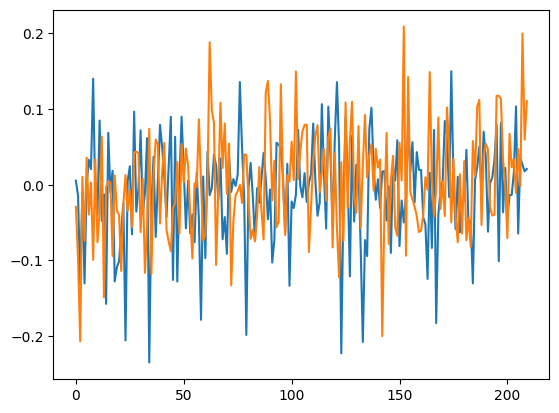

In [36]:
plt.plot(Vt[0], label = 'PC1')
plt.plot(Vt[1], label = 'PC2')
plt.show()

    Question 7.f

Best k: 48


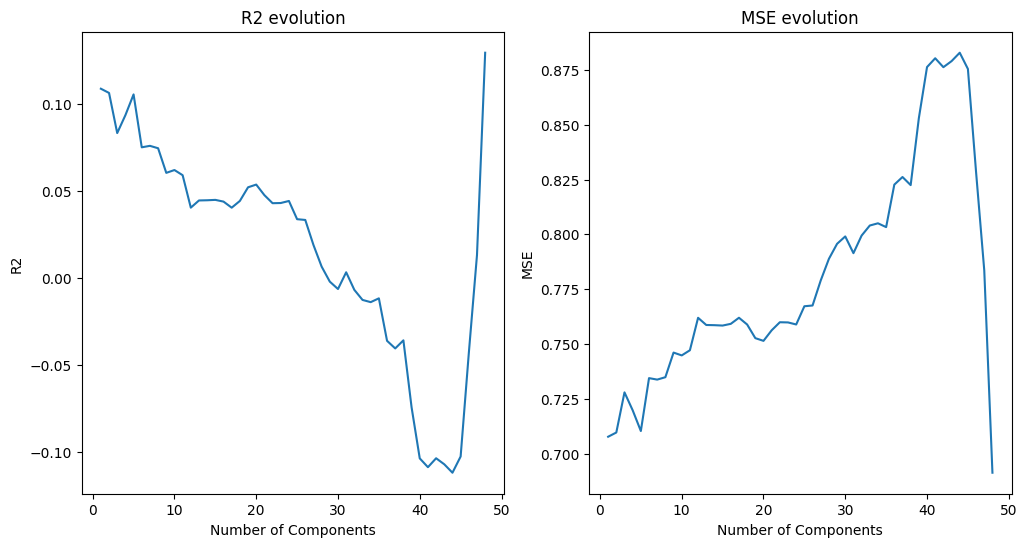

In [37]:
# Run OLS on projected data using PCR
R2_scores = []
mse_scores = []
n_component = X_train_scaled.shape[1] + 1
n_component = 49
for k in range(1, n_component):
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    model = LinearRegression()
    R2_scores.append(r2_score(y_test_scaled, model.fit(X_train_pca, y_train_scaled).predict(X_test_pca)))
    mse_scores.append(mse(y_test_scaled, model.fit(X_train_pca, y_train_scaled).predict(X_test_pca)))

best_k = np.argmax(R2_scores) + 1
print("Best k:", best_k)

# Plot the evolution of R-squared and MSE values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_component), R2_scores)
plt.xlabel('Number of Components')
plt.ylabel('R2')
plt.title('R2 evolution')

plt.subplot(1, 2, 2)
plt.plot(range(1, n_component), mse_scores)
plt.xlabel('Number of Components')
plt.ylabel('MSE')
plt.title('MSE evolution')
plt.show()

    Question 8

In [38]:
alpha_list = np.logspace(-3, 3, 30)

#List of models
ols_model
Ridge_model = RidgeCV(alphas= alpha_list, fit_intercept=False)
Lasso_model = LassoCV(alphas= alpha_list, fit_intercept=False)
ElasticNet_model = ElasticNetCV(alphas= alpha_list, fit_intercept=False, l1_ratio=0.5)

#Fit models on standardized data
ols_model.fit(X_train_scaled, y_train_scaled)
Ridge_model.fit(X_train_scaled, y_train_scaled)
Lasso_model.fit(X_train_scaled, y_train_scaled)
ElasticNet_model.fit(X_train_scaled, y_train_scaled)

#Compute R2 and MSE on train and test data
R2_train = [ols_model.score(X_train_scaled, y_train_scaled), Ridge_model.score(X_train_scaled, y_train_scaled), Lasso_model.score(X_train_scaled, y_train_scaled), ElasticNet_model.score(X_train_scaled, y_train_scaled)]
R2_test = [ols_model.score(X_test_scaled, y_test_scaled), Ridge_model.score(X_test_scaled, y_test_scaled), Lasso_model.score(X_test_scaled, y_test_scaled), ElasticNet_model.score(X_test_scaled, y_test_scaled)]
MSE_train = [mean_squared_error(y_train_scaled, ols_model.predict(X_train_scaled)), mean_squared_error(y_train_scaled, Ridge_model.predict(X_train_scaled)), mean_squared_error(y_train_scaled, Lasso_model.predict(X_train_scaled)), mean_squared_error(y_train_scaled, ElasticNet_model.predict(X_train_scaled))]
MSE_test = [mean_squared_error(y_test_scaled, ols_model.predict(X_test_scaled)), mean_squared_error(y_test_scaled, Ridge_model.predict(X_test_scaled)), mean_squared_error(y_test_scaled, Lasso_model.predict(X_test_scaled)), mean_squared_error(y_test_scaled, ElasticNet_model.predict(X_test_scaled))]
results = pd.DataFrame({"R2_train" : R2_train, "R2_test" : R2_test, "MSE_train" : MSE_train, "MSE_test" : MSE_test}, index=["OLS", "Ridge", "Lasso", "ElasticNet"])
print(results)
print("\n")

#Fit Models on Variable Selection methods
S, p_values, pp_values =forward_variable_selection(X_train_scaled,y_train_scaled)
X_train_scaled_S = np.take(X_train_scaled, S, 1)
X_test_scaled_S = np.take(X_test_scaled, S, 1)
ols_model.fit(X_train_scaled_S, y_train_scaled)
Ridge_model.fit(X_train_scaled_S, y_train_scaled)
Lasso_model.fit(X_train_scaled_S, y_train_scaled)
ElasticNet_model.fit(X_train_scaled_S, y_train_scaled)

#Compute R2 and MSE on train and test data
R2_train_vs = [ols_model.score(X_train_scaled_S, y_train_scaled), Ridge_model.score(X_train_scaled_S, y_train_scaled), Lasso_model.score(X_train_scaled_S, y_train_scaled), ElasticNet_model.score(X_train_scaled_S, y_train_scaled)]
R2_test_vs = [ols_model.score(X_test_scaled_S, y_test_scaled), Ridge_model.score(X_test_scaled_S, y_test_scaled), Lasso_model.score(X_test_scaled_S, y_test_scaled), ElasticNet_model.score(X_test_scaled_S, y_test_scaled)]
MSE_train_vs = [mean_squared_error(y_train_scaled, ols_model.predict(X_train_scaled_S)), mean_squared_error(y_train_scaled, Ridge_model.predict(X_train_scaled_S)), mean_squared_error(y_train_scaled, Lasso_model.predict(X_train_scaled_S)), mean_squared_error(y_train_scaled, ElasticNet_model.predict(X_train_scaled_S))]
MSE_test_vs = [mean_squared_error(y_test_scaled, ols_model.predict(X_test_scaled_S)), mean_squared_error(y_test_scaled, Ridge_model.predict(X_test_scaled_S)), mean_squared_error(y_test_scaled, Lasso_model.predict(X_test_scaled_S)), mean_squared_error(y_test_scaled, ElasticNet_model.predict(X_test_scaled_S))]
results = pd.DataFrame({"R2_train" : R2_train_vs, "R2_test" : R2_test_vs, "MSE_train" : MSE_train_vs, "MSE_test" : MSE_test_vs}, index=["OLS", "Ridge", "Lasso", "ElasticNet"])
print("Variable Selection : Reduction of the number of features from 210 to", len(S))
print(results)
print("\n")

#Fit Models on PCA with k=best_k
pca = PCA(n_components=best_k)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)
ols_model.fit(X_train_scaled_pca, y_train_scaled)
Ridge_model.fit(X_train_scaled_pca, y_train_scaled)
Lasso_model.fit(X_train_scaled_pca, y_train_scaled)
ElasticNet_model.fit(X_train_scaled_pca, y_train_scaled)

#Compute R2 and MSE on train and test data
R2_train_pca = [ols_model.score(X_train_scaled_pca, y_train_scaled), Ridge_model.score(X_train_scaled_pca, y_train_scaled), Lasso_model.score(X_train_scaled_pca, y_train_scaled), ElasticNet_model.score(X_train_scaled_pca, y_train_scaled)]
R2_test_pca = [ols_model.score(X_test_scaled_pca, y_test_scaled), Ridge_model.score(X_test_scaled_pca, y_test_scaled), Lasso_model.score(X_test_scaled_pca, y_test_scaled), ElasticNet_model.score(X_test_scaled_pca, y_test_scaled)]
MSE_train_pca = [mean_squared_error(y_train_scaled, ols_model.predict(X_train_scaled_pca)), mean_squared_error(y_train_scaled, Ridge_model.predict(X_train_scaled_pca)), mean_squared_error(y_train_scaled, Lasso_model.predict(X_train_scaled_pca)), mean_squared_error(y_train_scaled, ElasticNet_model.predict(X_train_scaled_pca))]
MSE_test_pca = [mean_squared_error(y_test_scaled, ols_model.predict(X_test_scaled_pca)), mean_squared_error(y_test_scaled, Ridge_model.predict(X_test_scaled_pca)), mean_squared_error(y_test_scaled, Lasso_model.predict(X_test_scaled_pca)), mean_squared_error(y_test_scaled, ElasticNet_model.predict(X_test_scaled_pca))]
results_pca = pd.DataFrame({"R2_train" : R2_train_pca, "R2_test" : R2_test_pca, "MSE_train" : MSE_train_pca, "MSE_test" : MSE_test_pca}, index=["OLS", "Ridge", "Lasso", "ElasticNet"])
print("PCA : Reduction of the number of features from 210 to", best_k)
print(results)


            R2_train   R2_test  MSE_train  MSE_test
OLS         0.559140  0.169933   0.440860  0.658961
Ridge       0.611951  0.323464   0.388049  0.537078
Lasso       0.534614  0.341788   0.465386  0.522531
ElasticNet  0.551401  0.346566   0.448599  0.518738


Variable Selection : Reduction of the number of features from 210 to 13
            R2_train   R2_test  MSE_train  MSE_test
OLS         0.591958  0.313216   0.408042  0.545214
Ridge       0.590782  0.325176   0.409218  0.535719
Lasso       0.591940  0.314603   0.408060  0.544112
ElasticNet  0.591863  0.316494   0.408137  0.542612


PCA : Reduction of the number of features from 210 to 48
            R2_train   R2_test  MSE_train  MSE_test
OLS         0.591958  0.313216   0.408042  0.545214
Ridge       0.590782  0.325176   0.409218  0.535719
Lasso       0.591940  0.314603   0.408060  0.544112
ElasticNet  0.591863  0.316494   0.408137  0.542612


Ridge, Lasso, and ElasticNet outperform OLS on both the training and test sets in terms of both MSE and R2.
The regularization techniques (Ridge, Lasso, ElasticNet) seem to generalize better to the test set compared to OLS.

When we reduce the dimensions of the data every model are equivalent